In [1]:
# Imports
from network import HopfieldNetwork
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Testing simple single pitch storage and denoising

We will start by trying to store an a440 pitch into the Hopfield network. We will then add noise to the pitch and see if the Hopfield network can recover the initial pitch.

### Extracting audio data

/var/folders/n5/xwtct4t51_zc76hz3mm3bcmc0000gn/T/ipykernel_45198/2994538207.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(file_path)


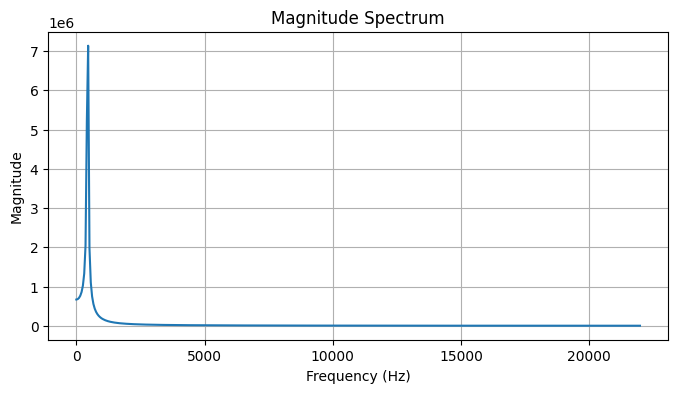

In [37]:
file_path = './audio/Sine_wave_440.wav'

# Read the wav file
sample_rate, data = wavfile.read(file_path)


# Take the fourier transform of the wav file, reduce the size for memory efficiency TODO: figure out optimal n
fft_result = np.fft.fft(data, len(data)//256)


# Frequencies corresponding to the FFT result
frequencies = np.fft.fftfreq(len(fft_result), 1/sample_rate)

# Plot the magnitude spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_result)[:len(frequencies)//2])
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

Above we can see a plot of the fourier transform, with a clear spike at 440Hz

### Converting audio data to binary format for Hopfield Network

Hopfield Networks require binary data, so we need to find a way to represent the audio data without losing too much information.

My first instinct is to reduce the frequency range to be 0-2000Hz, since the majority of fundamental (non-overtone) pitches in music are within this range. Then, we get a 2000 x 16 matrix, where each row index is an integer frequency (rounding will cause more errors lower in the pitch register) and the row's numbers represent a 16-bit number which is the magnitude of the respective frequency.

We define the below function to binarize audio data:

(430, 64)


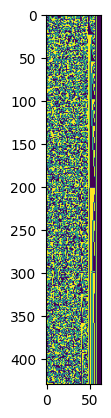

In [38]:
import struct
# Helper function
def float_to_bin_array(num):
    binary_repr = struct.pack('d', num)
    binary_array = np.array([int(b) for b in binary_repr], dtype=np.uint8)
    binary_array = np.unpackbits(binary_array)
    binary_array = np.array(binary_array, dtype=np.int8)
    binary_array[binary_array == 0] = -1
    return binary_array

def binarize_audio(magnitude_data):
    bin_data = []
    for d in magnitude_data:
        bin_arr = float_to_bin_array(d)
        bin_data.append(bin_arr)
    bin_data = np.array(bin_data)
    return bin_data

#binarize_audio(np.array([1,2,3,4,5]), None)
    
fft_mag_data = np.abs(fft_result[:len(frequencies)//2])

bin_data = binarize_audio(fft_mag_data)

#print(bin_data)

print(np.shape(bin_data))
plt.imshow(bin_data)

### Training the Hopfield network

The fourier data is essentially 1D - the frequency is an index for an array of magnitudes. To convert between indices and frequencies, we can use the following formula:

$$Index = \left \lfloor \frac{Frequency \times N}{Sample Rate} \right \rfloor$$

Where $N$ is the size of the fourier transform data.

Since we only want to focus on the positive frequencies, we will take the first half of the fourier transform array.

In [39]:
# Function to preprocess binary "image" of data
def preprocessing(img, w, h):
    # Flatten image
    flatten = np.reshape(img, (w*h))
    return flatten

# Initialize the Hopfield network
model = HopfieldNetwork()

# Only one data point to train, but input needs to be a list
train_data = [preprocessing(bin_data, w=len(bin_data), h=64)]

# Train the weights in the network
model.train_weights(train_data)

Start to train weights...
Weights initialized


100%|██████████| 1/1 [00:04<00:00,  4.93s/it]


Hebb rule step done


### Adding simple noise to the original audio

(430, 64)
(430,)


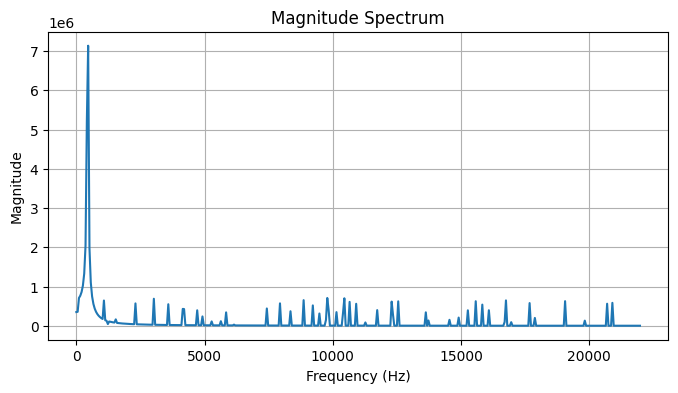

In [40]:
def get_corrupted_input(input, corruption_level):
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            # Choose random magnitude between 0 and the maximum magnitude
            magnitude = np.random.uniform(0, max(np.abs(fft_result)) * corruption_level)
            corrupted[i] = float_to_bin_array(magnitude)
    return corrupted

corrupted_data = get_corrupted_input(bin_data, corruption_level=0.1)

# Function to retrieve original mag data from corrupted data
def unbinarize_data(binarized_data):
    original_mags = []
    data = np.array(binarized_data, dtype=np.int8)
    data[data == -1] = 0
    data = np.array(data, dtype=np.uint8)
    for d in data:
        # Convert the binary array to a packed binary representation
        packed_binary = np.packbits(d)

        # Unpack the binary representation into a float64 value
        float64_value = struct.unpack('d', packed_binary.tobytes())[0]

        original_mags.append(float64_value)
    return np.array(original_mags)

print(corrupted_data.shape)
unbinarized_corrupted_data = unbinarize_data(corrupted_data)
print(unbinarized_corrupted_data.shape)
#print(unbinarized_corrupted_data)

# Plot the corrupted magnitude spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], unbinarized_corrupted_data)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

### Try to recover original signal

Start to predict...


100%|██████████| 1/1 [00:13<00:00, 13.59s/it]


27520
(430, 64)
[[-1. -1. -1. ... -1. -1.  1.]
 [-1. -1. -1. ... -1. -1.  1.]
 [-1.  1. -1. ... -1. -1.  1.]
 ...
 [-1.  1. -1. ... -1. -1. -1.]
 [ 1.  1.  1. ... -1. -1. -1.]
 [-1.  1.  1. ... -1. -1. -1.]]
(430,)
(430,)
Show prediction results...


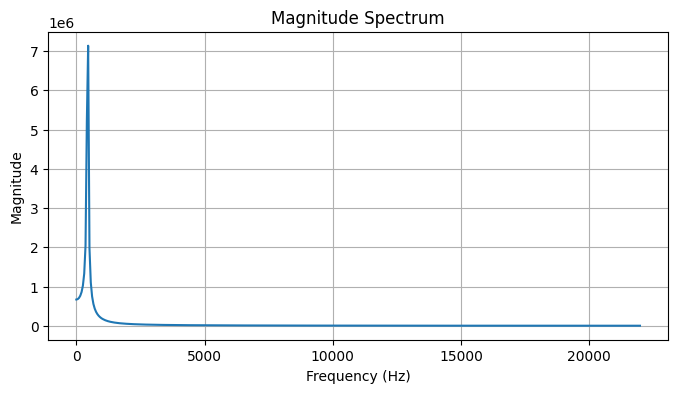

In [48]:
test_data = [preprocessing(corrupted_data, w=len(corrupted_data), h=64)]
predicted = model.predict(test_data, num_iter=50, threshold=0, asyn=False)
predicted = np.array(predicted)
print(predicted.size)
predicted = predicted.reshape(predicted.size // 64, 64)
print(predicted.shape)
print(predicted)
unbinarized_prediction = unbinarize_data(predicted)
print(unbinarized_prediction.shape)
print(frequencies[:len(frequencies)//2].shape)
print("Show prediction results...")
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], unbinarized_prediction)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

### Adding complex noise to the original audio

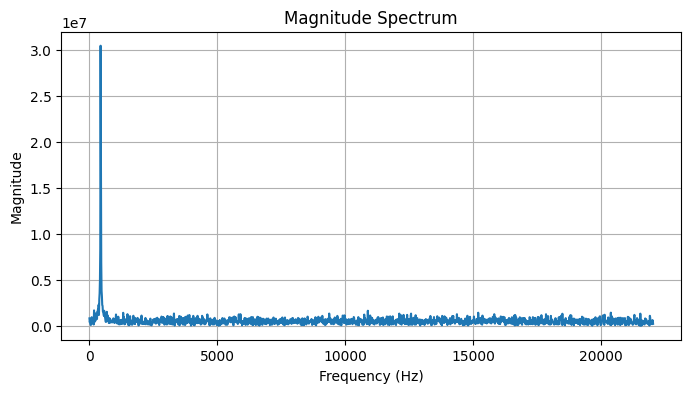

In [15]:
# Generate white noise
noise_level = 10000
noise = np.random.normal(0, noise_level, len(data))

# Add the noise to the audio data
noisy_audio = data + noise

# Clip the values to the valid range for 16-bit PCM audio
noisy_audio = np.clip(noisy_audio, -32768, 32767).astype(np.int16)

# Get the fourier transform of the data
noisy_fft = np.fft.fft(noisy_audio, len(noisy_audio)//64)

# Plot the magnitude spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], np.abs(noisy_fft)[:len(frequencies)//2])
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

### Make prediction (recover original audio)

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 17.07it/s]

Show prediction results...


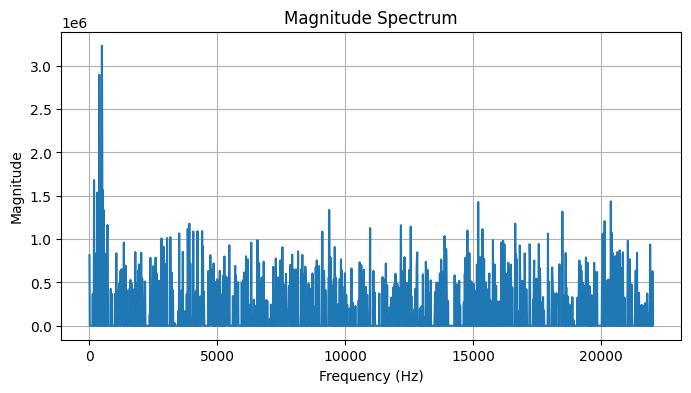

Show network weights matrix...


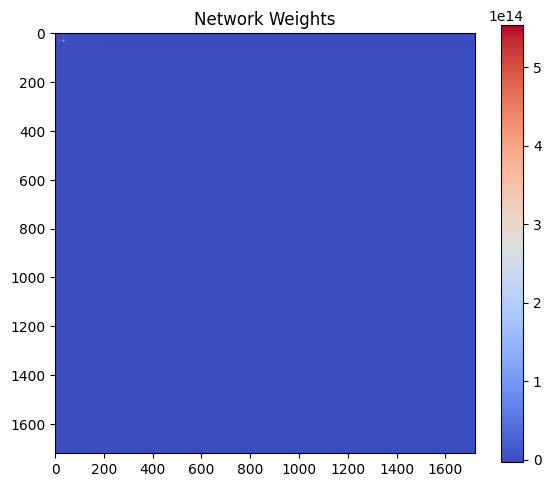

[[ 0.00000000e+00  2.55437095e+11  2.56308756e+11 ... -4.54647767e+10
  -4.54757949e+10 -4.54705357e+10]
 [ 2.55437095e+11  0.00000000e+00  2.56581321e+11 ... -4.55131259e+10
  -4.55241523e+10 -4.55188890e+10]
 [ 2.56308756e+11  2.56581321e+11  0.00000000e+00 ... -4.56684380e+10
  -4.56795013e+10 -4.56742216e+10]
 ...
 [-4.54647767e+10 -4.55131259e+10 -4.56684380e+10 ...  0.00000000e+00
   8.10275994e+09  8.10182349e+09]
 [-4.54757949e+10 -4.55241523e+10 -4.56795013e+10 ...  8.10275994e+09
   0.00000000e+00  8.10378598e+09]
 [-4.54705357e+10 -4.55188890e+10 -4.56742216e+10 ...  8.10182349e+09
   8.10378598e+09  0.00000000e+00]]


In [21]:
# Get just the positive frequencies
positive_noisy_fft = np.abs(noisy_fft)[:len(frequencies)//2]

predicted = model.predict([positive_noisy_fft], num_iter=20, threshold=0, asyn=True)
print("Show prediction results...")
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], predicted[0])
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()
print("Show network weights matrix...")
model.plot_weights()
print(model.W)

### Varying number of iterations

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 433.43it/s]

Show prediction results for num_iter=0...


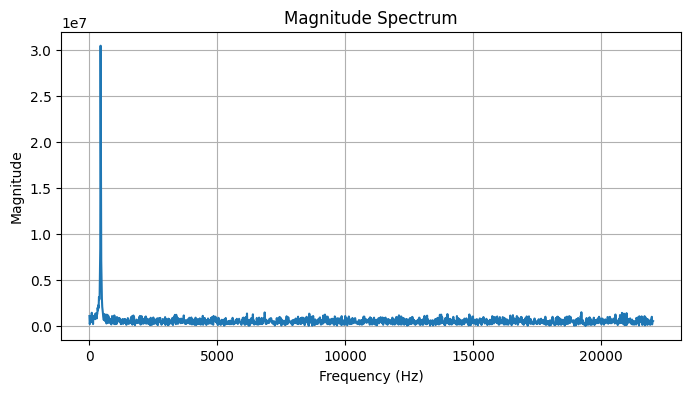

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 49.28it/s]

Show prediction results for num_iter=10...


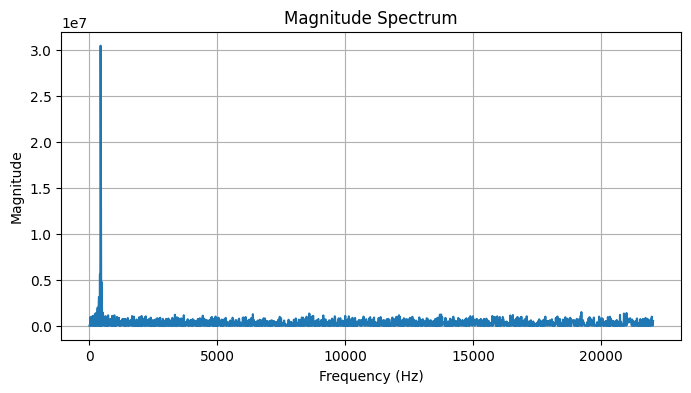

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 26.56it/s]

Show prediction results for num_iter=20...


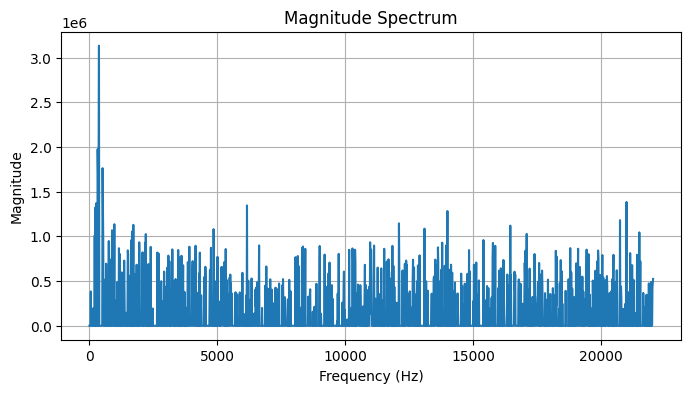

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


Show prediction results for num_iter=30...


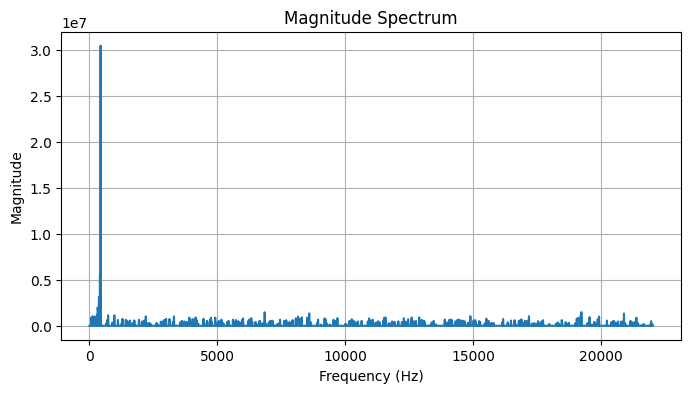

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 12.48it/s]

Show prediction results for num_iter=40...


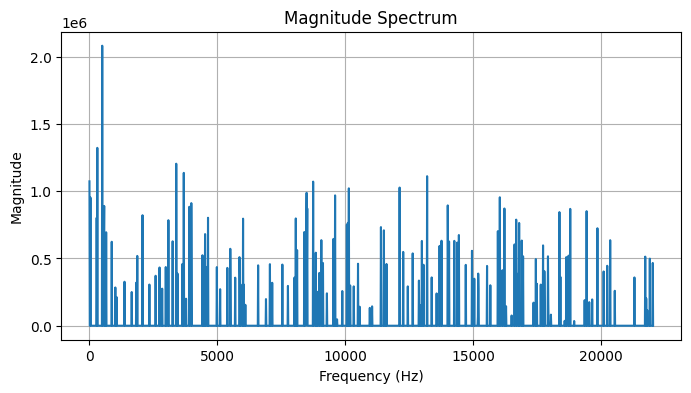

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


Show prediction results for num_iter=50...


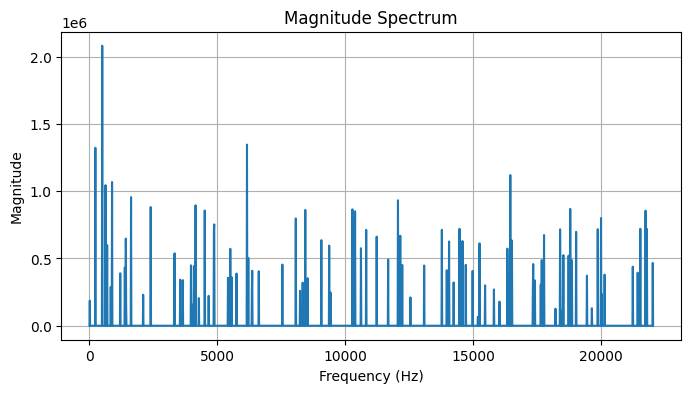

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


Show prediction results for num_iter=60...


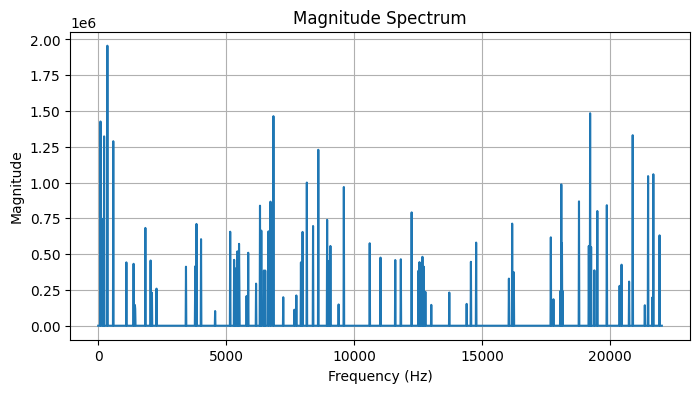

Start to predict...


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

Show prediction results for num_iter=70...


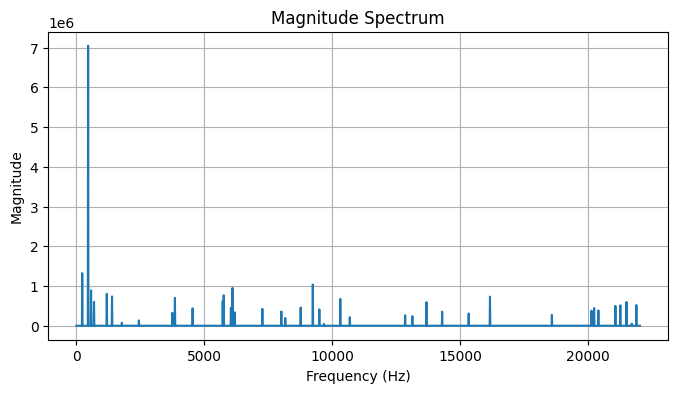

Start to predict...


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

Show prediction results for num_iter=80...


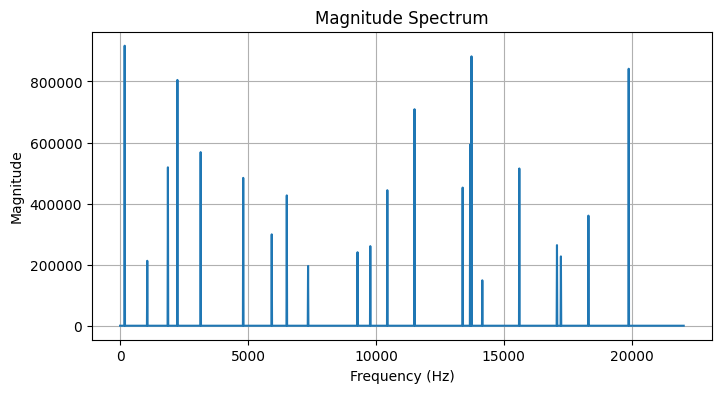

Start to predict...


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

Show prediction results for num_iter=90...


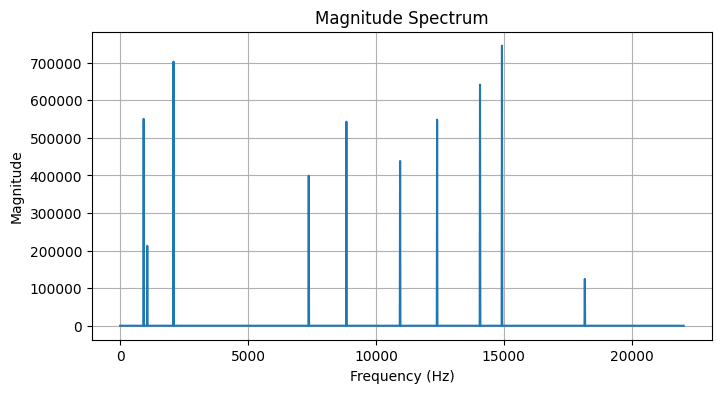

In [6]:
for i in range(0, 100, 10):
    predicted = model.predict([positive_noisy_fft], num_iter=i, threshold=50, asyn=True)
    print(f"Show prediction results for num_iter={i}...")
    plt.figure(figsize=(8, 4))
    plt.plot(frequencies[:len(frequencies)//2], predicted[0])
    plt.title('Magnitude Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.show()